In [27]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt

from astropy.timeseries import LombScargle

from astropy.convolution import convolve, Box1DKernel, Gaussian1DKernel

from matplotlib.gridspec import GridSpec

### runs in notebook_env

In [12]:
%matplotlib inline

In [34]:
plt.rcParams['figure.figsize'] = (10,8)
plt.rcParams['font.size'] = 12
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.markersize'] = 17
plt.rcParams['axes.labelsize'] = 15

In [5]:
def calc_lomb_scargle(t,y):
   oversample = 10
   tmax = t.max()
   tmin = t.min()
   df = 1.0 / (tmax - tmin)
   fmin = df
   fmax = 600 # maximum frequency in cycles per day (c/d)
 
   freq = np.arange(fmin, fmax, df / oversample)
   model = LombScargle(t, y)
   sc = model.power(freq, method="fast", normalization="psd")
 
   fct = np.sqrt(4./len(t))
   amp = np.sqrt(sc) * fct
   return freq*11.574, amp*1E6 # return frequency in muHz and amplitude in ppm

In [24]:
def yl_echelle(x, y, period, fmin=None, fmax=None, echelletype="single", offset=0.0):
    '''
    Make an echelle plot used in asteroseismology.
    
    Input parameters
    ----
    x: 1d array-like, freq
    y: 1d array-like, power spectrum
    period: float, length of each vertical stack (Dnu in a frequency echelle, DPi in a period echelle)
    fmin: float, minimum frequency to be plotted
    fmax: float, maximum frequency to be plotted
    echelletype: str, `single` or `replicated`
    offset: float, an amount by which the diagram is shifted horizontally
    
    Return
    ----
    z: a 2d numpy.array, folded power spectrum
    extent: a list, edges (left, right, bottom, top) 
    
    Users can create an echelle diagram with the following command:
    ----
    
    import matplotlib.pyplot as plt
    z, ext = echelle(freq, power, Dnu, fmin=numax-4*Dnu, fmax=numax+4*Dnu)
    plt.imshow(z, extent=ext, aspect='auto', interpolation='nearest')
    
    '''
    
    if fmin is None: fmin=0.
    if fmax is None: fmax=np.nanmax(x)

    fmin = fmin - offset
    fmax = fmax - offset
    x = x - offset

    fmin = 0.0 if fmin<0. else fmin - (fmin % period)

    # define plotting elements
    resolution = np.median(np.diff(x))
    # number of vertical stacks
    n_stack = int((fmax-fmin)/period) 
    # number of point per stack
    n_element = int(period/resolution) 

    fstart = fmin - (fmin % period)
    
    z = np.zeros([n_stack, n_element])
    base = np.linspace(0, period, n_element) if echelletype=='single' else np.linspace(0, 2*period, n_element)
    for istack in range(n_stack):
        z[-istack-1,:] = np.interp(fmin+istack*period+base, x, y)
    
    extent = (0, period, fstart, fstart+n_stack*period) if echelletype=='single' else (0, 2*period, fstart, fstart+n_stack*period)
        
    return z, extent

In [20]:
highmass_rc_newvals = pd.read_csv('../datatables/highmass_rc_newvals.csv')
highmass_rc_newvals

,KIC,numax,new_numax,smooth_numax,Delnu,o_Teff,o_log(g),o_[Fe/H],g_Teff,g_Teff_e,...,a_log(g),a_log(g)_e,a_[Fe/H],a_[Fe/H]_e,L_Teff,L_Teff_e,L_log(g),L_log(g)_e,L_[Fe/H],L_[Fe/H]_e
0,3347458,39.99,40.32,41.422682,3.360,5000,2.519,0.18,NaN,NaN,...,2.525,0.039,0.165,0.007,NaN,NaN,NaN,NaN,NaN,NaN
1,8378545,48.82,48.07,48.952072,3.952,5058,2.608,0.22,NaN,NaN,...,3.142,0.059,0.157,0.007,5009.00,32.00,2.761,0.053,0.323,0.030
2,5978324,49.10,48.78,50.072904,4.024,5051,2.610,-0.07,NaN,NaN,...,2.701,0.050,-0.098,0.008,NaN,NaN,NaN,NaN,NaN,NaN
3,10068490,66.42,58.84,60.906533,5.206,5189,2.747,-0.14,5740.95,4.38,...,2.769,0.062,-0.201,0.010,5254.75,37.05,2.699,0.061,-0.216,0.035
4,4756133,80.81,80.29,83.967767,5.865,5152,2.831,0.11,NaN,NaN,...,3.014,0.056,0.091,0.008,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109,10162765,88.56,85.53,89.092562,6.760,4948,2.862,0.18,NaN,NaN,...,2.858,0.049,0.076,0.008,5099.89,22.44,2.974,0.034,0.085,0.018
110,3430048,35.82,33.63,37.856607,3.487,5079,2.474,0.17,NaN,NaN,...,2.502,0.039,0.106,0.007,NaN,NaN,NaN,NaN,NaN,NaN
111,7116721,50.86,50.97,53.768334,4.522,5028,2.624,-0.26,NaN,NaN,...,NaN,NaN,NaN,NaN,4798.39,26.51,2.677,0.044,0.049,0.025
112,7347076,90.59,90.65,94.236618,7.216,5386,2.890,-0.17,NaN,NaN,...,NaN,NaN,NaN,NaN,5076.47,46.21,2.915,0.076,-0.007,0.044


In [6]:
from astropy.io import fits

In [7]:
lightcurve = fits.open('../data/kepseismic_LCs/KIC10068490_LC.fits')
lightcurve.info()

Filename: ../data/kepseismic_LCs/KIC10068490_LC.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      81   ()      
  1                1 BinTableHDU     16   71964R x 2C   [D, D]   
  2                1 ImageHDU         8   (71964,)   int16   


In [8]:
lightcurve[1].columns

ColDefs(
    name = 'TIME'; format = 'D'; unit = 'days'
    name = 'FLUX'; format = 'D'; unit = 'ppm'
)

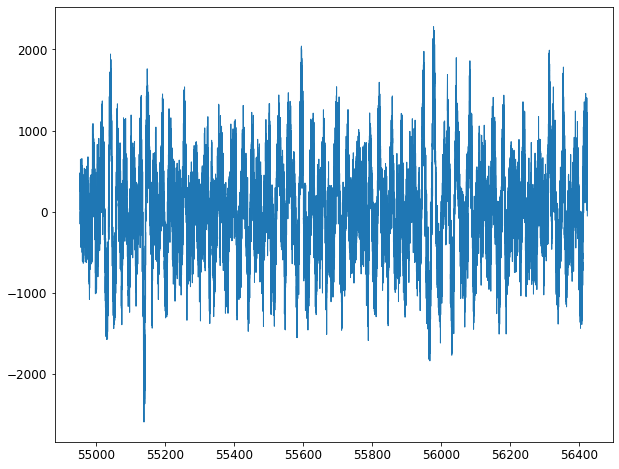

In [35]:
plt.plot(lightcurve[1].data['TIME'],lightcurve[1].data['FLUX'])
plt.show()

In [32]:
def initialize_star_kepseismic(star_name,delta_nu,nu_max):
    lightcurve = fits.open('../data/kepseismic_LCs/KIC'+str(star_name[4:])+'_LC.fits')
    time = lightcurve[1].data['TIME']
    flux = lightcurve[1].data['FLUX']
    
    
#     if star_name == 'KIC 9286851':
#         flux = np.asarray(lc_echelle.flux.value)
#         smoothed_flux = convolve(flux, Gaussian1DKernel(20),boundary='extend')
#         filtered_flux = flux/smoothed_flux
#         flux = filtered_flux
#         freq,amp = calc_lomb_scargle(lc_echelle.time.value,filtered_flux)
#     else:
    flux = np.asarray(flux)
    flux = flux/1000000 +1 # convert to ppm
    freq,amp = calc_lomb_scargle(time,flux)
    power = amp**2
    smooth_percent = 0.02

    fig = plt.figure(figsize=[15,8],constrained_layout=True)

    gs = GridSpec(3, 2, figure=fig)
    ax1 = fig.add_subplot(gs[:, 0])
    ax2 = fig.add_subplot(gs[0, 1])
    ax3 = fig.add_subplot(gs[1, 1])
    ax4 = fig.add_subplot(gs[2, 1])
    
    if star_name in ['KIC 10384595','KIC 3747623','KIC 6529078']: #the anamolous peak stars
        idx = (nu_max*0.5 < freq) & (freq < nu_max*1.5)
        loc = np.sum((freq < nu_max*0.5)) + np.argmax(amp[idx]**2)
        freq_res = np.median(np.diff(freq))
    #     fres = np.median(np.diff(freq))
        w = int(delta_nu/freq_res*0.03)
        amp[loc-w:loc+w] = 0.
                
        ## now we need to interpolate over the blank part
        masked_freq = np.concatenate((freq[:loc-w],freq[loc+w:]))
        masked_amp = np.concatenate((amp[:loc-w],amp[loc+w:]))
        interpolated = sp.interpolate.interp1d(masked_freq,masked_amp)
        amp[loc-w:loc+w] = interpolated(freq[loc-w:loc+w])

    freq_res = np.median(np.diff(freq))
    
    z, ext = yl_echelle(freq, 
                     convolve(power, Box1DKernel((delta_nu*0.02)/freq_res)),
                     delta_nu, 
                     fmin=nu_max*0.5, fmax=nu_max*1.5, echelletype="replicated")
    z = np.sqrt(z) #sqrt scaling
    ax1.imshow(z, extent=ext, aspect='auto', interpolation='nearest', cmap='BuPu')
    ax1.set_xlabel("Frequency mod "+str("{0:.2f}").format(delta_nu) + " ($\mu$Hz)")
    ax1.axvline(delta_nu,color='grey',linestyle='--',alpha=0.5)
    
    
#     echelle.plot_echelle(freq, amp**2, delta_nu, scale='sqrt', smooth=True, ax=ax1,
#                         fmin=nu_max*0.5,fmax=nu_max*1.5,smooth_filter_width=(delta_nu*0.03)/freq_res)

#     ax2.scatter(lc_echelle.time.value,lc_echelle.flux.value,s=5)
    ax2.scatter(time,flux,s=5)
    ax2.set_xlabel('time')
    ax2.set_ylabel('flux')

    ax3.plot(freq,power,linewidth=1)
    ax3.plot(freq,convolve(power, Box1DKernel((delta_nu*smooth_percent)/freq_res)),linewidth=1,color='r')
    # ax3.set_ylim(0,500)
    ax3.set_yscale('log')
    ax3.set_xscale('log')
    ax3.set_xlim(0.5,250)
    ax3.set_xlabel(r'frequency ($\mu$Hz)')
    ax3.set_ylabel('power')


    ax4.plot(freq,power,linewidth=1)
    ax4.plot(freq,convolve(power, Box1DKernel((delta_nu*smooth_percent)/freq_res)),linewidth=1,color='r')
    ax4.axvline(nu_max,color='grey',linestyle='--',alpha=0.5)
    subset = amp[(nu_max*0.8 < freq) & (freq < nu_max*1.2)]**2
    peak = max(subset)
    if star_name == 'KIC 10384595':
        peak = 500
    ax4.set_ylim(0,peak*1.2)
#     ax4.set_ylim(0,600)
    ax4.set_xlim(nu_max*0.5,nu_max*1.5)
    ax4.set_xlabel(r'frequency ($\mu$Hz)')
    ax4.set_ylabel('power')

    fig.suptitle(star_name,fontsize=20)
    plt.savefig('../data/kepseismic_grids/KIC'+star_name[4:])
    plt.show()
    
    ## save the lightcurve and power spectrum to a file so we don't have to query MAST every time
    lightcurve = np.concatenate(([time],[flux]))
    lightcurve_frame = pd.DataFrame(lightcurve.transpose(),columns=['time','flux'])
    lightcurve_frame.to_csv('../data/kepseismic_LCs/KIC'+star_name[4:]+'_LC.csv',index=False)
    powerspec = np.concatenate(([freq[freq < 267]],[amp[freq < 267]**2],[amp[freq < 267]]))
    powerspec_frame = pd.DataFrame(powerspec.transpose(),columns=['freq','power','amp'])
    powerspec_frame.to_csv('../data/kepseismic_LCs/KIC'+star_name[4:]+'_PS.csv',index=False)

/var/folders/5_/9nz8zb3j1nd7ngnmb4btgpjh0000gq/T/ipykernel_19256/1213842534.py:14: RuntimeWarning: invalid value encountered in sqrt
  amp = np.sqrt(sc) * fct


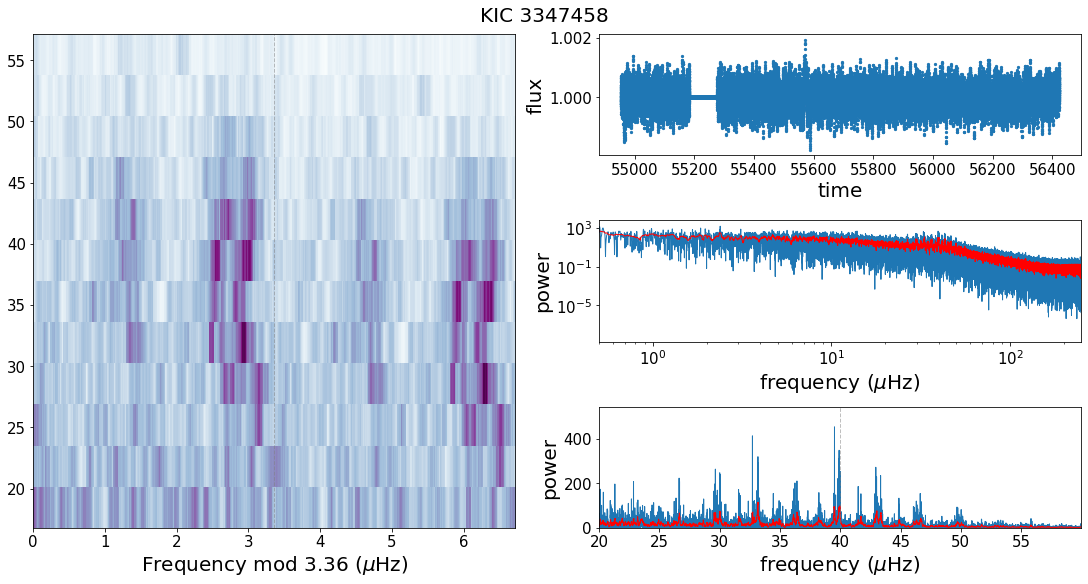

/var/folders/5_/9nz8zb3j1nd7ngnmb4btgpjh0000gq/T/ipykernel_19256/1213842534.py:14: RuntimeWarning: invalid value encountered in sqrt
  amp = np.sqrt(sc) * fct


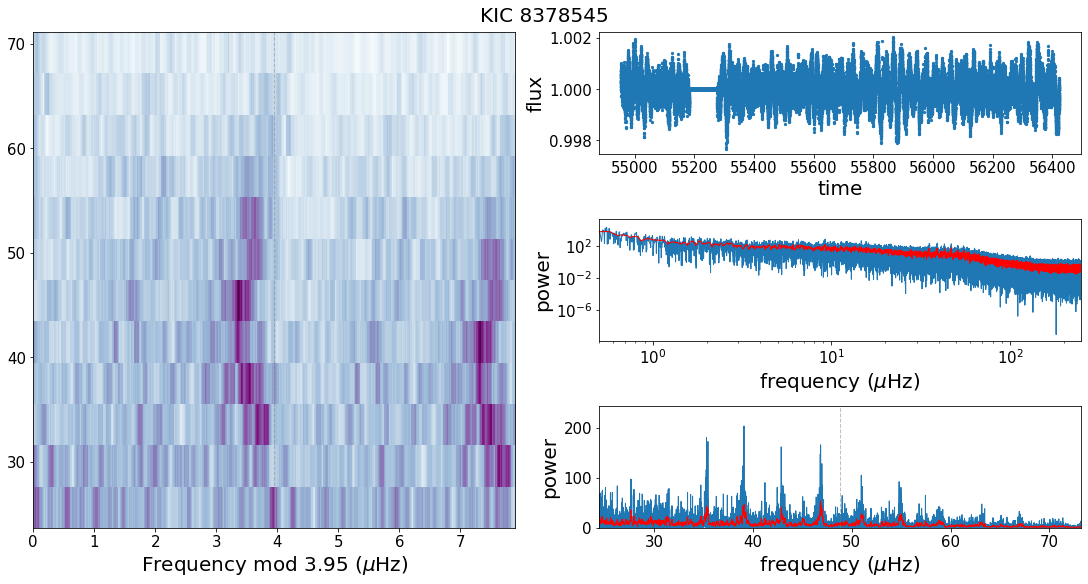

/var/folders/5_/9nz8zb3j1nd7ngnmb4btgpjh0000gq/T/ipykernel_19256/1213842534.py:14: RuntimeWarning: invalid value encountered in sqrt
  amp = np.sqrt(sc) * fct


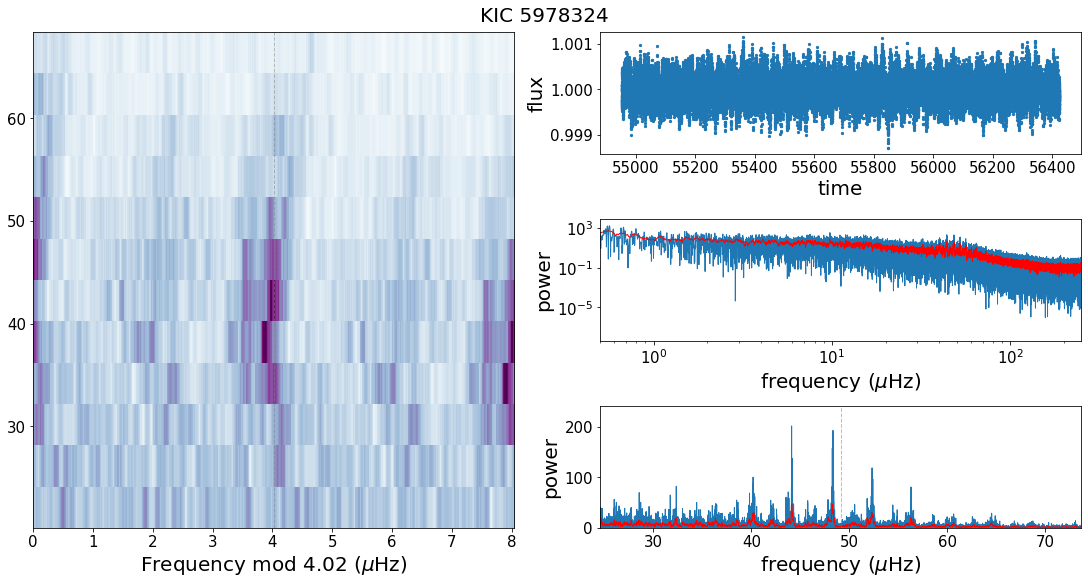

/var/folders/5_/9nz8zb3j1nd7ngnmb4btgpjh0000gq/T/ipykernel_19256/1213842534.py:14: RuntimeWarning: invalid value encountered in sqrt
  amp = np.sqrt(sc) * fct


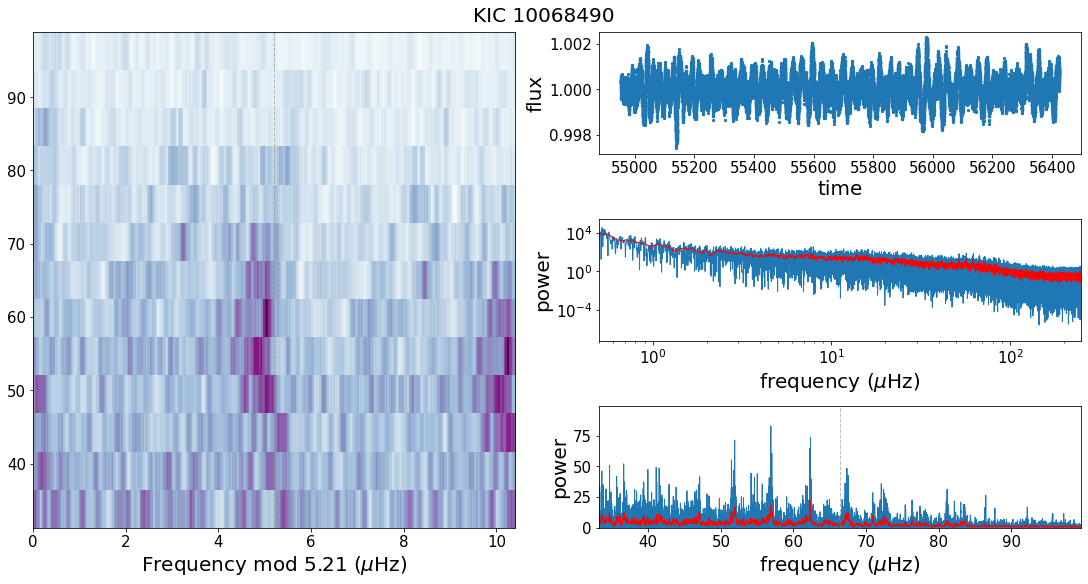

In [33]:
for i in range(0,4):#len(highmass_rc_newvals)):
    initialize_star_kepseismic('KIC '+str(highmass_rc_newvals['KIC'][i]),highmass_rc_newvals['Delnu'][i],
                    highmass_rc_newvals['numax'][i])